In [2]:
## Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt5
import time
from libDiagram import*

In [3]:
get_ipython().run_line_magic('matplotlib', 'inline')

1.0000000000000002


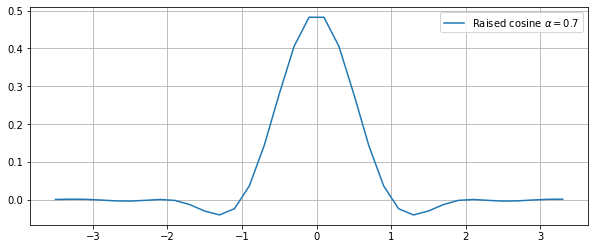

In [4]:
def get_filter(name, T, rolloff=None,amplitude=1,norm=False):
    def rc(t, beta,amplitude):
        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return amplitude*(np.sinc(t)*np.cos(np.pi*beta*t)/(1-(2*beta*t)**2))
    def rrc(t, beta,amplitude):
        return amplitude*(np.sin(np.pi*t*(1-beta))+4*beta*t*np.cos(np.pi*t*(1+beta)))/(np.pi*t*(1-(4*beta*t)**2))
        
    # rolloff is ignored for triang and rect
    if name == 'rect':
        return lambda t: (abs(t/T)<0.5).astype(int)    
    if name == 'triang': 
        return lambda t: (1-abs(t/T)) * (abs(t/T)<1).astype(float)
    elif name == 'rc':
        if norm: return lambda t: rc(t/T, rolloff,amplitude)/np.sqrt(np.sum(rc(t/T, rolloff,amplitude)**2)) 
        else :   return lambda t: rc(t/T, rolloff,amplitude)
    elif name == 'rrc':
        if norm: return lambda t: rrc(t/T, rolloff,amplitude)/np.sqrt(np.sum(rrc(t/T, rolloff,amplitude)**2))
        else :   return lambda t: rrc(t/T, rolloff,amplitude)


# # function to calculate the spectrum of the input signal
## Funcion Lambda
Fs = 1000     # sampling frequency
T  = 100      # time duration we want to look at
tf  = np.arange(-T, T, 1/Fs)  # the corresponding time samples
spec = lambda x: abs(np.fft.fftshift(np.fft.fft(x, 4*len(tf))))/Fs

Brau  = 1
Tbaud = 1.0/Brau
oversampling=5
Nbaud = 7.0
t = np.arange(-0.5*Tbaud*Nbaud, 0.5*Tbaud*Nbaud, float(Tbaud+0.0001)/oversampling) #sumo un pequeño valor a Tbaud por una condicion que se va cuando el oversampling es de 4 y roll off de 0.5 da infinito la valuacion en g(t)
rolloff=0.7
g = get_filter('rc', Tbaud, rolloff=rolloff,amplitude=3,norm=1)  # RC filter with rolloff alpha=0.5

print(np.sum(np.sum(g(t)**2)))

g0= g(np.array([1e-9]))
G = spec(g(t))
f = np.linspace(-Brau/2, Brau/2, len(G)) 
plt.figure(figsize=(10,4))
plt.plot(t, g(t), label=r'Raised cosine $\alpha=%2.1f$'%rolloff)
# plt.plot(f,G)
# plt.plot(t, get_filter('rect', T)(t), label=r'Rectangular')
# plt.plot(t, get_filter('triang', T)(t), label=r'Triangular', lw=3)
plt.legend()
plt.grid()

In [118]:
range_roll_off =  np.random.randint(0,2,10)
print(range_roll_off)

[1 0 0 0 1 1 0 0 0 1]


prbs=[-1  1  1 -1 -1  1  1 -1  1 -1 -1  1  1 -1  1 -1]


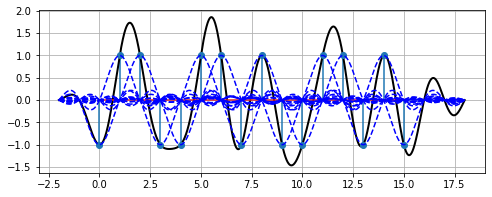

In [116]:
b = np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])
d = 2*b-1
#-------------PRBS---------------
# Nsymb = 18
# b = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1
# d = np.zeros(oversampling*Nsymb)
# d[0:len(d):int(oversampling)] = b
print ("prbs=%s" % d)
T=Tbaud
def get_signal(g, d):
    """Generate the transmit signal as sum(d[k]*g(t-kT))"""
    t = np.arange(-2*T, (len(d)+2)*T, 1/Fs)
    g0 = g(np.array([1e-8])) #devuelve el coeficiente de mayor amplitud
    xt = sum(d[k]*g(t-k*T) for k in range(len(d)))
    return t, xt/g0


fig = plt.figure(figsize=(8,3))
t, xt = get_signal(g, d)
plt.plot(t, xt, 'k-', lw=2, label='$x(t)$')
plt.stem(T*np.arange(len(d)), d)
for k in range(len(d)):
    plt.plot(t, d[k]*g(t-k*T), 'b--', label='$d[k]g(t-kT)$')

#plt.legend()
plt.grid()

[-1.  1.  1. -1. -1.  1. -1.  1.  1. -1.]


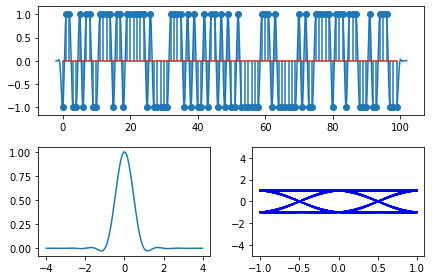

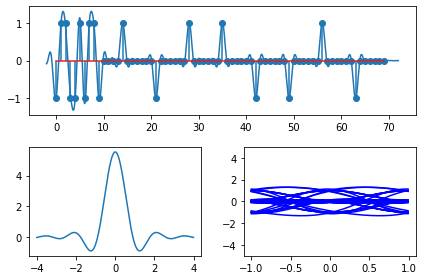

In [88]:
def drawFullEyeDiagram(xt):
    """Draw the eye diagram using all parts of the given signal xt"""
    samples_perT = Fs*T
    samples_perWindow = 2*Fs*T
    parts = []
    startInd = 2*samples_perT   # ignore some transient effects at beginning of signal
    
    for k in range(int(len(xt)/samples_perT) - 6):
        parts.append(xt[startInd + k*samples_perT + np.arange(samples_perWindow)])
    parts = np.array(parts).T
    
    t_part = np.arange(-T, T, 1/Fs)
    plt.plot(t_part, parts, 'b-')

def drawSignals(g, data=None):
    """Draw the transmit signal, the used filter and the resulting eye-diagram
    into one figure."""
    N = 100;
    if data is None:
        data = 2*((np.random.randn(N)>0))-1
        # fix the first 10 elements for  keeping the shown graphs constant
        # between eye diagrams
        data[0:10] = 2*np.array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0])-1
    
    t, xt = get_signal(g, data)

    plt.subplot(223)
    t_g = np.arange(-4*T, 4*T, 1/Fs)
    plt.plot(t_g, g(t_g))

    plt.subplot(211)
    plt.plot(t, xt)
    plt.stem(data)
    
    plt.subplot(224)
    drawFullEyeDiagram(xt); plt.ylim((-5,5))
    plt.tight_layout()

def showRCEyeDiagram(alpha):
    g = get_filter('rc', T=1, rolloff=alpha)
    drawSignals(g)

fig = plt.figure()
showRCEyeDiagram(alpha=1)

fig = plt.figure()
N = 100
# data = 3-2*np.arange(4)[np.random.randint(4, size=N)]
data = d
print (data[:10])
drawSignals(g, data=data)

plt.show()

____________________Bienvenido____________________
__Eliga algunos de siguientes test para revisar___
Test1: 
      Rolloff: 0.2
      Amplitud: 4
      Normalizacion: False
      Oversampling: 3
      Tipo de filtro: rrc
      Numero de baudios: 2
Test2: 
      Rolloff: 0.9
      Amplitud: 5
      Normalizacion: False
      Oversampling: 5
      Tipo de filtro: rrc
      Numero de baudios: 2
Test3: 
      Rolloff: 0.3
      Amplitud: 1
      Normalizacion: False
      Oversampling: 6
      Tipo de filtro: rc
      Numero de baudios: 3
Test4: 
      Rolloff: 0.4
      Amplitud: 5
      Normalizacion: False
      Oversampling: 6
      Tipo de filtro: rrc
      Numero de baudios: 9
Test5: 
      Rolloff: 0.2
      Amplitud: 2
      Normalizacion: False
      Oversampling: 6
      Tipo de filtro: rc
      Numero de baudios: 5
Test6: 
      Rolloff: 1.0
      Amplitud: 3
      Normalizacion: False
      Oversampling: 4
      Tipo de filtro: rrc
      Numero de baudios: 7
Test7: 
      Roll

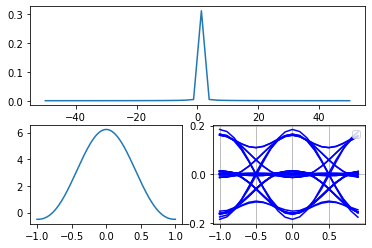

In [105]:
## Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt5
import time
from libDiagram import*

#parametros 
#consultar si estos deben ser aleatorios!!!
range_roll_off =  np.random.randint(0,11,size=10)/10.0  #np.arange(0.1,1.1,.1)
amplitud =  np.random.randint(1,7,size=10)              #np.arange(1,11,1)
oversampling = np.random.randint(1,8,size=10)           #np.arange(1,11,1)
Nbaud = np.random.randint(2,10,size=10)                 #np.arange(3,14,1)
filterRamdon = np.random.randint(0,2,size=10) #eligo un filtro aleatorio
tipeFilter=['rc','rrc']
T=1
Fs = 100
#generacion del diccionario
cases_dict = dict()
for i in range(0,10):
    cases_dict1 = { 'Test{}'.format(i+1): {'rolloff' : round(range_roll_off[i],1),
                                           'amplitud' : amplitud[i],
                                           'normalizacion' : False,
                                           'oversampling' : oversampling[i],
                                           'tipo de filtro': tipeFilter[filterRamdon[i]],
                                           'numero de baudios': Nbaud[i]}
                                        }
    cases_dict.update(cases_dict1)
#interfaz
print("bienvenido".capitalize().center(50,"_"))
print("eliga algunos de siguientes test para revisar".capitalize().center(50,"_"))
for key in cases_dict:
    print(key + ': ')
    for key1 in cases_dict[key]:
        print(" "*6 + key1.capitalize() + ": " + str(cases_dict[key].get(key1)))

print('_'*60)

while(True):
    test_input = input('Elige un Test o presione x para salir')
    if test_input =='x':
        break
    elif 0<int(test_input)<11 :
        Test = 'Test{}'.format(str(test_input))
        print('Eligio '+ Test)
        for key in cases_dict[Test]:
            print(" "*6 + key.capitalize() + ": " + str(cases_dict[Test].get(key)))
        print('_'*60)
        rolloff  = cases_dict[Test]['rolloff']
        amplitud = cases_dict[Test]['amplitud']
        Nbaud    = cases_dict[Test]['numero de baudios']
        oversampling = cases_dict[Test]['oversampling']
        tipo = cases_dict[Test]['tipo de filtro']
        t = np.arange(-0.5*T*Nbaud, 0.5*T*Nbaud, 1/(Fs*oversampling))
        g = get_filter(tipo,T,rolloff=rolloff,amplitude=amplitud)
        g0=g(np.array(1e-10))
        G = spec(g(t)/g0)
        f = np.linspace(-Fs/2, Fs/2, len(G))
        #PRBS
        Nsymb = 10
        b = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1
        d = np.zeros(oversampling*Nsymb)
        d[0:len(d):int(oversampling)] = b
        d[0:10] = 2*np.array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0])-1
        t1, xt = get_signal(g,d)
        plt.figure()
        plt.subplot(223)
        plt.plot(t, g(t), label=r'Raised cosine $\alpha=%2.1f$'%rolloff)
        plt.subplot(211)
        plt.plot(f, G, label=r'Respuesta en Frecuencia $\alpha=%2.1f$'%rolloff)
        plt.subplot(224)
        drawFullEyeDiagram(xt/g0)
        plt.legend()
        plt.grid()
        plt.show()
    else :
        print('no seleccion ningun test valido'.capitalize())
# consultar normalizacion y bien por el numero de baudios

hola


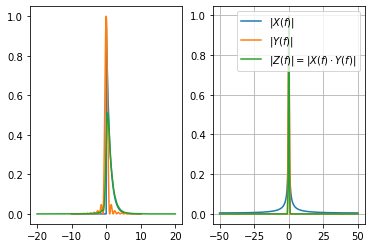

In [32]:
## Funcion Lambda
Fs = 100    # sampling frequency
T  = 10      # time duration we want to look at
t  = np.arange(-T, T, 1/Fs)  # the corresponding time samples

# define our two functions
x = lambda t: np.exp(-abs(t)) * (t>=0)
y = lambda t: np.sinc(t)**2

# the resulting time range, when convolving both signals
t_conv = np.arange(-2*T, 2*T, 1/Fs)[:-1]

plt.figure()
plt.subplot(121) 
plt.plot(t, x(t), label='$x(t)$')
plt.plot(t, y(t), label='$y(t)$')
z = np.convolve(x(t), y(t))/Fs
plt.plot(t_conv, z, label='$z(t)$')

# # function to calculate the spectrum of the input signal
spec = lambda x: abs(np.fft.fftshift(np.fft.fft(x, 4*len(t))))/Fs

X = spec(x(t))
Y = spec(y(t))
Z = spec(z)
f = np.linspace(-Fs/2, Fs/2, len(X))

plt.subplot(122)
plt.plot(f, X, label='$|X(f)|$')
plt.plot(f, Y, label='$|Y(f)|$')
plt.plot(f, Z, label='$|Z(f)|=|X(f)\\cdot Y(f)|$')
plt.grid()
plt.legend()
plt.show()


____________________Bienvenido____________________
__Eliga algunos de siguientes test para revisar___
Test1: 
      Rolloff: 0.7
      Amplitud: 3
      Normalizacion: 1
      Oversampling: 5
      Tipo de filtro: rc
      Numero de baudios: 7
Test2: 
      Rolloff: 0.2
      Amplitud: 3
      Normalizacion: 1
      Oversampling: 3
      Tipo de filtro: rrc
      Numero de baudios: 5
Test3: 
      Rolloff: 0.6
      Amplitud: 4
      Normalizacion: 0
      Oversampling: 5
      Tipo de filtro: rrc
      Numero de baudios: 2
Test4: 
      Rolloff: 0.3
      Amplitud: 1
      Normalizacion: 0
      Oversampling: 4
      Tipo de filtro: rc
      Numero de baudios: 6
Test5: 
      Rolloff: 0.8
      Amplitud: 4
      Normalizacion: 0
      Oversampling: 7
      Tipo de filtro: rrc
      Numero de baudios: 5
Test6: 
      Rolloff: 1.0
      Amplitud: 2
      Normalizacion: 0
      Oversampling: 2
      Tipo de filtro: rc
      Numero de baudios: 6
Test7: 
      Rolloff: 0.8
      Amplitud: 

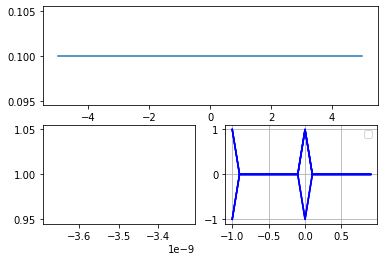

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt5
import time
from libDiagram import*

#parametros 
#consultar si estos deben ser aleatorios!!!
range_roll_off =  np.random.randint(0,11,size=10)/10.0+0.01  #np.arange(0.1,1.1,.1)
amplitud =  np.random.randint(1,7,size=10)              #np.arange(1,11,1)
oversampling = np.random.randint(1,8,size=10)           #np.arange(1,11,1)
Nbaud = np.random.randint(2,10,size=10)                 #np.arange(3,14,1)
filterRamdon = np.random.randint(0,2,size=10)           #eligo un filtro aleatorio
tipeFilter=['rc','rrc']
nomalizacion = np.random.randint(0,2,10)
Brau  = 1.0
Tbaud = 1.0/Brau

#generacion del diccionario
cases_dict = dict()
for i in range(0,10):
    cases_dict1 = { 'Test{}'.format(i+1): {'rolloff' : round(range_roll_off[i],1),
                                           'amplitud' : amplitud[i],
                                           'normalizacion' : nomalizacion[i],
                                           'oversampling' : oversampling[i],
                                           'tipo de filtro': tipeFilter[filterRamdon[i]],
                                           'numero de baudios': Nbaud[i]}
                                        }
    cases_dict.update(cases_dict1)
#interfaz
print("bienvenido".capitalize().center(50,"_"))
print("eliga algunos de siguientes test para revisar".capitalize().center(50,"_"))
for key in cases_dict:
    print(key + ': ')
    for key1 in cases_dict[key]:
        print(" "*6 + key1.capitalize() + ": " + str(cases_dict[key].get(key1)))

print('_'*60)

while(True):
    test_input = input('Elige un Test o presione <x> para salir')
    if test_input =='x':
        break
    elif 0<int(test_input)<11 :
        Test = 'Test{}'.format(str(test_input))
        print('Eligio '+ Test)
        for key in cases_dict[Test]:
            print(" "*6 + key.capitalize() + ": " + str(cases_dict[Test].get(key)))
        print('_'*60)
        rolloff  = cases_dict[Test]['rolloff']
        amplitud = cases_dict[Test]['amplitud']
        normalizacion = cases_dict[Test]['normalizacion']
        Nbaud    = cases_dict[Test]['numero de baudios']
        oversampling = cases_dict[Test]['oversampling']
        tipo = cases_dict[Test]['tipo de filtro']
        t = np.arange(-0.5*Tbaud*Nbaud, 0.5*Tbaud*Nbaud, float(Tbaud+0.00001)/oversampling) #sumo un pequeño valor a Tbaud por una condicion que se va cuando el oversampling es de 4 y roll off de 0.5 da infinito la valuacion en g(t)
        g = get_filter(tipo,Tbaud,rolloff=rolloff,amplitude=amplitud,norm=normalizacion)
        g0 = g(np.array(1e-9))
        G = spec(g(t))
        f = np.linspace(-Brau/2, Brau/2, len(G))
        #PRBS
        Nsymb = 10
        b = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1
        # d = np.zeros(oversampling*Nsymb)
        # d[0:len(d):int(oversampling)] = b
        d=b
        d[0:10] = 2*np.array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0])-1
        t1, xt = get_signal(g,d)
        plt.figure()
        plt.subplot(223)
        plt.plot(t, g(t), label=r'Raised cosine $\alpha=%2.1f$'%rolloff)
        plt.subplot(211)
        plt.plot(f, G, label=r'Respuesta en Frecuencia $\alpha=%2.1f$'%rolloff)
        plt.subplot(224)
        drawFullEyeDiagram(xt/g0)
        plt.legend()
        plt.grid()
        plt.show()
    else :
        print('no seleccion ningun test valido'.capitalize())